# Classification binaire: prédire la détention du baccalauréat dans le recensement 

## 1. Présentation
Dans ce tutoriel, nous allons voir comment utiliser une forêt aléatoire en Python avec l'implémentation de `scikit-learn`. Nous présentons les étapes suivantes: la préparation des données, la construction du modèle, l'entraînement du modèle, l'optimisation des hyperparamètres et quelques éléments d'interprétation des résultats.

Le jeu de données est issu du recensement de la population (Insee) et contient des informations individuelles issues du recensement, telles que l'âge, le niveau d'éducation, la situation professionnelle, etc. L'objectif sera de prédire si un individu a obtenu le baccalauréat en fonction de ses autres caractéristiques observées.


## 2. Préparation de l'environnement

### 2.1 Importation des bibliothèques nécessaires

In [ ]:
# Importation des bibliothèques pour la manipulation des données
import os
import s3fs
import zipfile
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import copy

# Bibliothèques pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliothèques pour le traitement des données
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

# Bibliothèques pour le modèle et l'évaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Pour mesurer le temps d'exécution
import time

### 2.2 Chargement des données

In [ ]:
# Définir la liste des variables à conserver
variable_list = [
    'AGED', 'APAF', 'CATL', 'CATPC', 'COUPLE', 'CS1', 'DEPT', 'DIPL', 
    'EMPL', 'HLML', 'ILETUD', 'ILT', 'IMMI', 'INAI', 'INATC', 'INFAM', 
    'INPER', 'INPERF', 'IRAN', 'LIENF', 'LPRF', 'LPRM', 'METRODOM', 'MOCO',
     'MODV', 'NA17', 'NA5', 'NAIDT', 'NBPI', 'NENFR', 'NPERR', 'ORIDT', 'SEXE', 
     'SFM', 'STAT_CONJ', 'STATR', 'STOCD', 'SURF', 'TACTD16', 
     'TP', 'TRANS', 'TYPC', 'TYPFC'
]

In [ ]:
# Se connecter au bucket
endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint}, anon=True)

# Charger les données individuelles  du recensement
with fs.open('s3://oliviermeslin/rp/data_census_individuals.parquet', 'rb') as file:
    data_census_individuals = pd.read_parquet(file, columns = variable_list)

# Charger la documentation
# doc_census_individuals = read_csv_data("documentation/doc_census_individuals.csv")

In [ ]:
# Afficher les premières lignes du jeu de données
data_census_individuals.head()

## 3. Préparation des données

### 3.1 Echantillonnage des données
Compte tenu de l'objectif pédagogique de ce tutoriel, nous tirons un échantillon aléatoire de taille restreinte (1 % des observations), représentatif de l'ensemble des données initiales, afin d'accélérer les calculs dans les sections suivantes.

In [ ]:
# Échantillonner les données (1/100)
data_sample = data_census_individuals.sample(frac=1/100, random_state=123)

### 3.2 Création de la variable cible

Nous créons la variable que l'on va tâcher de prédire: une variable indicatrice qui vaut 1 pour les individus détenteurs du baccalauréat, 0 pour les autres.

In [ ]:
# Voir la répartition des classes de diplôme
print(data_sample['DIPL'].isna().sum())  # Vérification des valeurs manquantes
print(data_sample['DIPL'].value_counts())  # Distribution des classes

In [ ]:
# Préciser l'odre des catégories de DIPL (ZZ suivi des valeurs numériques croissantes)
categories = ['ZZ'] + [f"{i:02}" for i in range(1, 20)]
data_sample['DIPL'] = pd.Categorical(data_sample['DIPL'], categories=categories, ordered=True)

# Créer la variable binaire 'bac'
data_sample['bac'] = (data_sample['DIPL'] > '13').astype(int)

# Afficher le résultat
print(data_sample[['DIPL', 'bac']].head(20))
print(data_sample['bac'].value_counts())  # Distribution des classes

# Supprimer la colonne 'DIPL' du DataFrame (car c'est un prédicteur parfait du baccalauréat)
data_sample = data_sample.drop(columns=['DIPL'])

### 3.3 Préparation des variables explicatives (_features_)
Dans cette étape, on supprime des variables non pertinentes ou comprenant trop de modalités. On supprime également des variables liées à l'âge pour en conserver une seule (`AGED`).

In [ ]:
# Suppression des variables liées à l'âge (autres que AGED) et des variables non pertinentes ou avec trop de modalités (pour commencer)
data_clean = copy.deepcopy(data_sample)

In [ ]:
# Créer une fonction qui teste si une chaîne de caractères peut être convertie en un entier
def can_convert_to_int(value):
    try:
        int(value)  # Attempt to convert the value to an integer
        return True
    except ValueError:
        return False

In [ ]:
# Transformer en variables continues toutes les variables qui peuvent l'être
for var in data_clean.columns.tolist():
    if data_clean[var].dtype.name == "category":
        if set([category for category in data_clean[var].cat.categories if not can_convert_to_int(category)]) <= set(['X', 'Z']):
            data_clean[var] = data_clean[var].cat.rename_categories({'X': '99', 'Z': '999'})
            data_clean[var] = data_clean[var].astype(int)

On sépare ensuite les _features_ et la variable-cible.

In [ ]:
# Séparer les features (X) et la variable cible (y : bac)
X = data_clean.drop(columns=['bac'])
y = data_clean['bac']

### 3.4 Séparation des ensembles d'entraînement et de test
On utilise la fonction [`train_test_split()`](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) pour séparer l'ensemble d'entraînement et l'ensemble de test. La stratification en fonction de $y$ assure que la proportion des classes est la même dans les ensembles d'entraînement et de test.

In [ ]:
# Diviser les données en ensembles d'entraînement (80%) et de test (20%) avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

## 4. Construire le modèle complet

Nous allons construire le modèle complet en utilisant __un _pipeline_ `scikit-learn`, dont l'usage est très fortement recommandé__. Ce _pipeline_ va comprendre deux étapes: le _preprocessing_ des données, puis la forêt aléatoire proprement dite.

Un _pipeline_ `scikit-learn` est un objet informatique qui permet d'assurer une exécution cohérente de plusieurs étapes de traitement des données. Par un exemple, un _pipeline_ permet de réaliser la normalisation des variables, le traitement des valeurs manquantes, l'encodage des variables catégorielles, et l'entraînement d'un modèle __en une seule étape__. Utiliser un _pipeline_ simplifie les codes et garantit que les mêmes transformations sont appliquées aux données d'entraînement et de test, ce qui réduit le risque d'erreur et augmente la reproductibilité des résultats. Si vous n'êtes pas habitué à les utiliser, il est fortement recommandé de lire la [documentation officielle sur ce sujet](https://scikit-learn.org/1.5/modules/compose.html) et l'[excellente formation](https://pythonds.linogaliana.fr/content/modelisation/6_pipeline.html) de Lino Galiana.

### 4.1 Le préprocessing des données
Le _préprocessing_ des données est construit avec la fonction  [`ColumnTransformer()`](https://scikit-learn.org/1.5/modules/generated/sklearn.compose.ColumnTransformer.html) de `scikit` et n'est pas le même selon le type des variables:
- on applique un _one-hot-encoding_ aux variables catégorielles, avec la fonction [`OneHotEncoder()`](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OneHotEncoder.html) de `scikit`. On choisit d'encoder toutes les modalités (`drop=None`). L'option `handle_unknown='error'` signifie que le modèle renverra une erreur s'il rencontre une modalité inconnue lors de l'utilisation en prédiction.
- On applique aucune transformation aux variables numériques car les méthodes ensemblistes sont invariantes aux transformations monotones des _features_. On utilise donc l'option "passthrough".

On utilise la fonction [`make_column_selector()`](https://scikit-learn.org/1.5/modules/generated/sklearn.compose.make_column_selector.html) permet d'appliquer le bon _preprocessing_ en fonction du type des variables, sans avoir à en faire une liste explicite.

In [ ]:
# Construire la première étape du pipeline (préprocessing des données)

# One-hot-encoding des variables catégorielles
preproc_categor = OneHotEncoder(drop=None, handle_unknown='error')

# On ne modifie pas les variables numériques
preproc_numeric = "passthrough"

# On rassemble les deux morceaux du preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        # One-hot encoding des variables catégorielles
        ("cat", preproc_categor, make_column_selector(dtype_include=["category", "object"])),
        # Standardisation des variables numériques
        ("num", preproc_numeric, make_column_selector(dtype_exclude=["category", "object"]))
    ]
)

### 4.2 Définir le _pipeline_

On définit ensuite la seconde étape du traitement: le modèle de _machine learning_ proprement dit. En l'occurrence, il s'agit d'une forêt aléatoire.

In [ ]:
# Construire la seconde étape du pipeline (la forêt aléatoire)
rf_algorithm = RandomForestClassifier(random_state=42, n_jobs=-1)

Une fois que les étapes de modélisation sont définies, on peut les rassembler explicitement dans un _pipeline_ pour constituer le modèle complet. C'est ce modèle que nous allons utiliser tout au long de ce tutoriel.

In [ ]:
# Construire le pipeline complet
rf_model = Pipeline(
    steps=[
        # Etape 1: preprocessing
        ("preprocessor", preprocessor),
        # Etape 2: le modèle de ML
        ("classifier", rf_algorithm)
    ]
)

### 4.3 Automatiser la construction du modèle
Maintenant que nous avons vu comment construire un modèle complet sous forme de _pipeline_, nous allons automatiser cette tâche sous la forme d'une fonction. Cela permettra de générer un nouveau modèle à chaque fois que nous en aurons besoin. Ci-dessous, on définit la fonction `create_model()` qui reproduit le code présenté précédemment, et renvoie le modèle complet.

In [ ]:
def create_model():
    # One-hot-encoding des variables catégorielles
    preproc_categor = OneHotEncoder(drop=None, handle_unknown='error')

    # On ne modifie pas les variables numériques
    preproc_numeric = "passthrough"

    # On rassemble les deux morceaux du preprocessing
    preprocessor = ColumnTransformer(
        transformers = [
            # One-hot encoding des variables catégorielles
            ("cat", preproc_categor, make_column_selector(dtype_include=["category", "object"])),
            # Standardisation des variables numériques
            ("num", preproc_numeric, make_column_selector(dtype_exclude=["category", "object"]))
        ]
    )

    # Construire la seconde étape du pipeline (la forêt aléatoire)
    rf_algorithm = RandomForestClassifier(random_state=42, n_jobs=-1)    
    
    # Construire le pipeline complet
    rf_model = Pipeline(
        steps=[
            # Etape 1: preprocessing
            ("preprocessor", preprocessor),
            # Etape 2: le modèle de ML
            ("classifier", rf_algorithm)
        ]
    )
    return(rf_model)

## 5. Entraîner une première forêt aléatoire 
Dans cette section, nous allons entraîner une toute première forêt avec les __hyperparamètres par défaut__. Il est important de noter que ces valeurs par défaut varie d'une implémentation à l'autre. Dans `scikit-learn`, [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) a les valeurs par défaut suivantes:

|Hyperparamètre | Signification | Valeur par défaut |
|:----:|----|:----:|
|`n_estimators` | Nombre d'arbres dans la forêt | 100 |
|`max_features` | Nombre de variables à considérer pour déterminer le meilleur _split_ | 'sqrt'|
|`min_samples_leaf` | Nombre minimum d'échantillons dans une feuille terminale | 1 |

### 5.1 Entraînement du modèle

On commence par créer un modèle grâce à la fonction `create_model()`.

In [ ]:
# Créer un modèle
model1 = create_model()

In [ ]:
# Entraînement du modèle
start_time = time.time()
model1.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps d'exécution du modèle Random Forest : {elapsed_time:.2f} secondes")

### 5.2 Evaluation sur le jeu de test

La matrice de confusion permet de visualiser les erreurs de classification.
Le rapport de classification donne des métriques importantes comme la précision, le rappel et le F1-score.

In [ ]:
# Prédictions sur les données de test
y_pred = model1.predict(X_test)

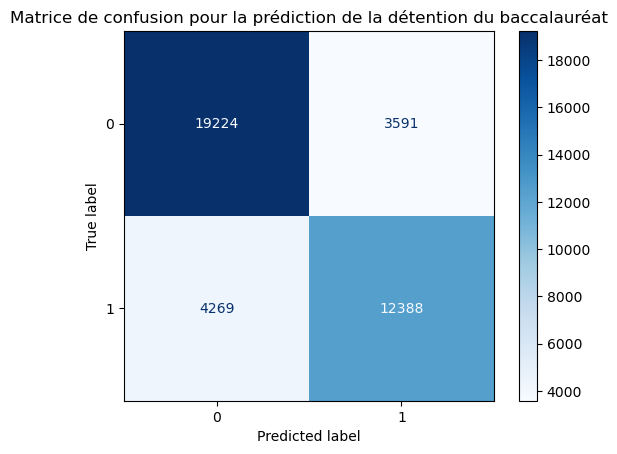

In [151]:
# Évaluer la performance avec une matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred, labels=model1["classifier"].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model1["classifier"].classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion pour la prédiction de la détention du baccalauréat")
plt.show()

In [ ]:
# Rapport de classification
print(classification_report(y_test, y_pred))

## 6. Optimisation des hyperparamètres

### 6.1 Influence du nombre d'arbres (n_estimators)

L'augmentation du nombre d'arbres améliore la stabilité et la précision des estimations. Toutefois, un nombre d'arbre élevé peut considérablement allongés le temps de calcul. 

L'objectif est de trouver un compromis entre stabilité et temps de calcul.

Méthode: On observe comment l'accuracy évolue avec le nombre d'arbres.
Cela permet de déterminer si l'augmentation du nombre d'arbres améliore significativement la performance.

In [ ]:
n_estimators_range = [10, 50, 100, 200, 500, 1000]
scores = []

for n in n_estimators_range:
    
    print(f"Entraînement en cours avec n_estimators = {n}")  # Affichage de la valeur actuelle

    rf_model = RandomForestClassifier(
        n_estimators=n, 
        max_features='sqrt', 
        min_samples_leaf=100, 
        random_state=123,
        n_jobs=-1  # Parallélise la construction des arbres
    )
    score = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy').mean()
    scores.append(score)

plt.plot(n_estimators_range, scores, marker='o')
plt.xlabel('Nombre d\'arbres (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Influence de n_estimators')
plt.grid()
plt.show()


## Influence du nombre de caractéristiques (max_features)

In [ ]:
max_features_options = ['sqrt', 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, None]
scores = []
d = X_train.shape[1]  # Nombre total de caractéristiques dans le jeu de données

# Stocker les résultats pour le tri lors de la visualisation
results = []

for mf in max_features_options:

    print(f"Entraînement en cours avec max_features = {mf} ({num_features} features)")  # Affichage de la valeur actuelle

    # Calculer le nombre de features sélectionnés pour chaque option
    if isinstance(mf, float):  # Si mf est une fraction
        num_features = int(mf * d)
    elif mf == 'sqrt':  # Si mf est 'sqrt'
        num_features = int(np.sqrt(d))
    elif mf == 'log2':  # Si mf est 'log2'
        num_features = int(np.log2(d))
    elif mf is None:  # Si mf est None
        num_features = d
    else:
        num_features = None

    # Entraîner et évaluer le modèle
    rf = RandomForestClassifier(
        n_estimators=100,
        max_features=mf,
        min_samples_leaf=100,
        random_state=123,
        n_jobs=-1  # Parallélise la construction des arbres
    )
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()

    # Ajouter les résultats pour tri ultérieur
    results.append((mf, num_features, score))

# Trier les résultats par ordre croissant du nombre de features
results.sort(key=lambda x: x[1])

# Extraire les labels et scores triés
labels = [f"{mf} ({num_features})" for mf, num_features, _ in results]
scores = [score for _, _, score in results]

# Visualisation
plt.plot(labels, scores, marker='o')
plt.xlabel('max_features (nombre de features)')
plt.ylabel('Accuracy moyenne (validation croisée)')
plt.title('Influence de max_features')
plt.grid(True)
plt.xticks(rotation=45)  # Incliner les labels pour une meilleure lisibilité
plt.show()


## Influence de la taille minimale des feuilles (min_samples_leaf)

Pour de faibles valeurs du nombre minimum d'observations par feuille (noeud terminal), le modèle risque de sur-ajuster les données d'entraînement; pour des valeurs élevées, le modèle devient plus simple, ce qui peut entraîner un sous-ajustement.

L'objectif est donc de trouver un compromis optimal entre ces deux situations.


In [ ]:
# Différentes valeurs de min_samples_leaf à tester
min_samples_leaf_range = [5, 10, 50, 100, 500]
scores = []

for min_samples_leaf in min_samples_leaf_range:
        
    print(f"Entraînement en cours avec min_samples_leaf = {min_samples_leaf}")  # Affichage de la valeur actuelle

    rf_model = RandomForestClassifier(
        n_estimators=300,  # Fixé à 500 arbres
        max_features='sqrt',
        min_samples_leaf=min_samples_leaf,
        random_state=123
    )
    score = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy').mean()
    scores.append(score)

# Tracer les résultats
plt.plot(min_samples_leaf_range, scores, marker='o')
plt.xlabel('Valeurs de min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Influence de min_samples_leaf')
plt.grid()
plt.show()

## Recherche de la meilleure combinaison d'hyperparamètres: Grid Search pour optimiser plusieurs hyperparamètres à la fois

GridSearchCV de scikit-learn permet d'optimiser de manière simultanée plusieurs hyperparamètres.


### Définition de la grille de paramètres

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 10, 50, 100]
}

### Mise en place de la Grid Search

In [ ]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=123),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Exécution du Grid Search
grid_search.fit(X_train, y_train)

### Résultats de la Grid Search : identification du modèle le plus performant

In [ ]:
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure précision :", grid_search.best_score_)

# 6. Evaluer la performance du modèle optimisé par Grid Search

## Prédictions et évaluation

In [ ]:
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Précision sur le jeu de test :", test_score)

In [ ]:
# Prédictions sur les données de test
y_pred = best_model.predict(X_test)

In [ ]:
# Évaluer la performance avec une matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion pour la prédiction du niveau de diplôme")
plt.show()

In [ ]:
# Rapport de classification
print(classification_report(y_test, y_pred))

## Comparaison avec le modèle initial

In [ ]:
# Calcul de l'accuracy sur le jeu de test pour les deux modèles
initial_accuracy = rf_model.score(X_test, y_test)
optimized_accuracy = best_model.score(X_test, y_test)

print(f"Accuracy du modèle initial : {initial_accuracy:.4f}")
print(f"Accuracy du modèle optimisé : {optimized_accuracy:.4f}")

# 7. Interprétation du modèle : Importance des variables

## Extraction de l'importance des variables: leur contribution à la performance du modèle
L'importance des variables reflète leur contribution à la qualité des prédictions du modèle. Parmi les différentes mesures disponibles, nous utilisons ici la "Mean Decrease in Impurity" (MDI). Cette métrique évalue la contribution de chaque variable à la réduction de l'impureté moyenne dans l'arbre de décision. 
Pour chaque variable, elle correspond à la moyenne des réductions d’impureté (par exemple, l'indice de Gini ou l'entropie) qu’elle a engendrées dans tous les nœuds de tous les arbres où elle est impliquée. Les variables présentant la réduction moyenne d’impureté la plus élevée sont considérées comme les prédicteurs les plus importants.

In [ ]:
# Importance des variables (Mean Decrease in Impurity)
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

## Agrégation des importances pour les variables catégorielles

In [ ]:
# Rassembler l'importance des modalités d'une même variable
def calculate_aggregated_importance(X, feature_importances):
    """
    Agrège l'importance des variables catégorielles encodées en colonnes multiples.

    Args:
        X (pd.DataFrame): Les données d'entraînement (features).
        feature_importances (array): Les importances des variables calculées par le modèle.

    Returns:
        pd.DataFrame: Importance des variables agrégées par nom de variable.
    """
    # Récupérer les noms des colonnes
    feature_names = X.columns
    
    # Initialiser un dictionnaire pour stocker les importances agrégées
    aggregated_importance = {}

    for col in feature_names:
        # Identifier les variables spécifiques pour regrouper correctement
        if col.startswith('STAT_CONJ_'):
            variable = 'STAT_CONJ'
        elif col.startswith('STATR_'):
            variable = 'STATR'
        else:
            # Utiliser le préfixe par défaut basé sur le premier segment avant "_"
            variable = col.split('_')[0]
        
        # Additionner les importances pour chaque variable "parent"
        if variable in aggregated_importance:
            aggregated_importance[variable] += feature_importances[feature_names.get_loc(col)]
        else:
            aggregated_importance[variable] = feature_importances[feature_names.get_loc(col)]

    # Convertir en DataFrame trié par importance
    aggregated_df = pd.DataFrame({
        'Variable': aggregated_importance.keys(),
        'Importance': aggregated_importance.values()
    }).sort_values(by='Importance', ascending=False)

    return aggregated_df

In [ ]:
# Appeler la fonction pour regrouper les importances
aggregated_importance_df = calculate_aggregated_importance(X, best_model.feature_importances_)

# Afficher les résultats
print(aggregated_importance_df)

In [ ]:
# Charger les libellés des variables depuis le dictionnaire
doc_census_individuals_noms_variables = doc_census_individuals[['COD_VAR', 'LIB_VAR']].drop_duplicates()

In [ ]:
# Associer les libellés (descriptions) aux variables d'importance
importance_df_with_labels = aggregated_importance_df.merge(
    doc_census_individuals_noms_variables,
    left_on='Variable',
    right_on='COD_VAR',
    how='left'
)

## Visualisation des variables les plus importantes
La visualisation aide à comprendre quelles variables contribuent le plus à la prédiction.

In [ ]:
# Fonction pour visualiser les n variables les plus importantes
def plot_top_n_variables(importance_df, variable_col='Variable', importance_col='Importance', top_n=10):
    """
    Visualise les n variables les plus importantes à partir d'un DataFrame d'importance.

    Parameters:
    - importance_df (pd.DataFrame): Un DataFrame contenant les colonnes spécifiées.
    - variable_col (str): Le nom de la colonne contenant les noms des variables.
    - importance_col (str): Le nom de la colonne contenant les valeurs d'importance.
    - top_n (int): Le nombre de variables les plus importantes à afficher.
    """
    # Vérifier si les colonnes existent
    if variable_col not in importance_df.columns or importance_col not in importance_df.columns:
        raise ValueError(f"Les colonnes '{variable_col}' et/ou '{importance_col}' ne sont pas présentes dans le DataFrame.")

    # Trier par importance décroissante
    top_variables = importance_df.sort_values(by=importance_col, ascending=False).head(top_n)

    # Création du graphique
    plt.figure(figsize=(10, 8))
    plt.barh(top_variables[variable_col], top_variables[importance_col], color='steelblue')
    plt.xlabel("Importance")
    plt.ylabel("Variable")
    plt.title(f"Top {top_n} variables les plus importantes")
    plt.gca().invert_yaxis()  # Afficher les plus importantes en haut
    plt.show()

In [ ]:
# Visualisation des variables les plus importantes
plot_top_n_variables(
    importance_df = importance_df_with_labels,
    variable_col='LIB_VAR',
    importance_col='Importance',
    top_n=10
)